# Import Library


In [0]:
from pyspark.sql import *
import pandas as pd
import numpy as np
import gc
from datetime import datetime
import lifetimes
from lifetimes.plotting import plot_history_alive
import matplotlib
print(matplotlib.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
%matplotlib inline

from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter
from lifetimes.plotting import *

3.2.2

# 1. load Data

In [0]:
user_payment = spark.sql("select * from mytable").toPandas() 
history = spark.sql("select * from history ").toPandas()  
autolaps = spark.sql("select * from autolapse").toPandas()  

#1.1 Define Function For aggregate data

In [0]:
def Aggregate_data(df_rfa):
  ## กรองเอาเฉพาะ Transaction ที่ Pay Success
  df_rfa_2 = df_rfa[df_rfa['Status'].isin(['Success'])]
  df_rfa_2['SuccessDate_2'] = df_rfa_2['SuccessDate'].dt.strftime('%Y-%m-%d')
  
  
  ## กรอง User ที่คิดว่าเป็น User ทดสอบ ออก (Filter Out User Test)
  dropout_1 = df_rfa_2[df_rfa_2['CustomerName'].str.contains("ทดสอบ")]
  dropout_2 = df_rfa_2[df_rfa_2['CustomerName'].str.contains("test")]
  dropout_res = pd.concat([dropout_1,dropout_2] ,axis=0)['CustomerId'].unique()
  df_rfa_2 = df_rfa_2.loc[~df_rfa_2['CustomerId'].isin(dropout_res)].reset_index(drop=True)
  df_rfa_2['TranId'] = df_rfa_2['TranId'].astype(str)
  df_rfa_2['TranAmount'] = df_rfa_2['TranAmount'].astype(int)
  df_rfa_2['SuccessDate_2'] = pd.to_datetime(df_rfa_2['SuccessDate_2']) 

  return df_rfa_2

## Function Generate Threshold
def Threshold_explore(data,max_stop):
  num_range = np.arange(start=0.1, stop=max_stop, step=0.1)
  list_threshold = dict()
  list_data = list()
  for idx,nums in enumerate(num_range):
    
    ## Get threshold
    df = data[data['purchases_next60days'] <= nums]
    threshold_num = df[df['Frequency_count_date'] != 0]['CustomerId'].count() / df['CustomerId'].count()
    key = 'prd_purchase ='+ str(round(nums,2))
    
    ## Get Count User
    count_user_isactual = df[df['Frequency_count_date'] !=0]['CustomerId'].count()
    count_user = df['CustomerId'].count()
    
    
    ## Add To Dataframe
    list_data.append([key,round(threshold_num,3),count_user,count_user_isactual])
    #list_threshold.update({key:round(threshold_num,1)})
    
  dtf = pd.DataFrame(list_data,columns=['prd_purchase_key','score','count_user','count_user_isactual'])
    
  return dtf

#2. Exploration Data
 - Filter by condition

In [0]:
## look for distribution by name
pd.crosstab(history['name'] ,'c')

In [0]:
## เลือกเอาเฉพาะ Type เพราะแทนการซื้อ
history = history[history['name'].isin([....])]

In [0]:
history.groupby(['id']).agg({'id':'count'})

In [0]:
user_payment_1.head()
df_rfa = user_payment_1.copy()
df_rfa_2 = Aggregate_data(df_rfa)

In [0]:
df_rfa_2_1 = pd.concat([df_rfa_2,history[['id','useddate']].drop_duplicates()], axis=0, ignore_index=True)

In [0]:
df_rfa_2_1['SuccessDate'].fillna(value=df_rfa_2_1[~df_rfa_2_1['useddate'].isnull()]['useddate'] , inplace=True)

In [0]:
df_rfa_2_1

In [0]:
tt = df_rfa_2_1.copy()
tt['year'] = pd.to_datetime(tt['SuccessDate_2']).dt.year

In [0]:
print('Num Customer :>',len(tt['id'].unique()))
print('Num Transactions :>',len(tt['TranId'].unique()))

Num Customer :> 97619
Num Transactions :> 164951

In [0]:
df_rfa_2_1['year'] = df_rfa_2_1['SuccessDate'].dt.year

In [0]:
## Checkdata 
mjcouponhistory['useddate'].min()

Out[207]: Timestamp('2018-05-08 15:50:01.390634')

In [0]:
df_rfa_2_1.drop(columns='SuccessDate_2' ,inplace=True )

In [0]:
df_rfa_2_1['SuccessDate_2'] = pd.to_datetime(df_rfa_2_1['SuccessDate']).dt.strftime('%Y-%m-%d')

In [0]:
df_rfa_2_1 = df_rfa_2_1[df_rfa_2_1['SuccessDate_2'] >= '2018-05-08'].reset_index(drop=True)

In [0]:
df_rfa_2_1

##2. หา Segment ของกลุ่มตัวอย่างแต่ละคนก่อนว่าอยู่ Segment ไหน

In [0]:
profile = spark.sql(''' select  PartitionKey,date(DateOfBirth) from segment ''').toPandas()

In [0]:
df_rfa_2_1

In [0]:
##  Fix Date เพื่อลดการ ฺBias
df_get_last = df_rfa_2_1[df_rfa_2_1['SuccessDate_2'] < '2021-01-01']

user_last_purchase = df_get_last.groupby(['id']).agg({'SuccessDate_2':max})\
                    .rename(columns={'SuccessDate_2' : 'last_purchase'}).reset_index()
user_last_purchase['last_purchase'] = pd.to_datetime(user_last_purchase['last_purchase'])

In [0]:
print(len(user_last_purchase['id'].unique()))
print(len(df_rfa_2_1['id'].unique()))

82498
86498

In [0]:
user_segment = user_last_purchase.merge(profile,
                                       on='id',how='left')
user_segment['DateOfBirth'] = pd.to_datetime(user_segment['DateOfBirth'] , errors='coerce')
user_segment['ChildStage_2'] = (user_segment['last_purchase'] - user_segment['DateOfBirth']).dt.days *  (12.0/365.25)

In [0]:
def child_stage(data):
  if data["ChildStage_2"] < 0:
    return "Pregnant"
  if data["ChildStage_2"] <= 6:
    return "0-6 month"
  if data["ChildStage_2"] <= 12:
    return "7-12 month"
  if data["ChildStage_2"] <= 36:
    return "1-3 year"
  if data["ChildStage_2"] <= 72:
    return "3-6 year"
  if data["ChildStage_2"] > 72:
    return "6 year ++"
  else:
    return "None"

In [0]:
## Create Columns Tier Stage User
user_segment = user_segment.assign(ChildStage=user_segment.apply(child_stage, axis=1))

In [0]:
print(len(df_rfa_2_1['id'].unique()))
print(len(user_segment['id'].unique()))

86498
82498

In [0]:
df_rfa_2_prep = df_rfa_2_1.merge(user_segment,on='id',how='left')

In [0]:
df_rfa_2_prep['SuccessDate_2'].max()

Out[29]: '2021-03-22'

#3. Filter out User Group 1-3 Year


In [0]:
pd.crosstab(df_rfa_2_prep['ChildStage'],'H')

In [0]:
df_rfa_2_prep_1 = df_rfa_2_prep[df_rfa_2_prep['ChildStage'].isin(['1-3 year'])]
#df_rfa_2_prep_1 = df_rfa_2_prep[df_rfa_2_prep['ChildStage'].isin(['0-6 month','7-12 month','1-3 year'])]

In [0]:
df_rfa_2_prep_1.head()

In [0]:
df_rfa_2_prep_1.isnull().any()

##3.1 Maping เพื่อดูว่า Consumtion เท่าไร

In [0]:
df_lapse = autolaps[['id','refid','productname','successdate','consumptiondays','repurchase_alrt']]

In [0]:
autolaps[autolaps['productname'].str.contains('1,600')]['consumptiondays'].unique()

Out[35]: array([13, 53, 40, 26])

In [0]:
df_lapse_1 = df_lapse[['id','campaignid','SuccessDate','consumptiondays']]

In [0]:
df_rfa_2_prep_2 = df_rfa_2_prep_1.merge(df_lapse_1,on=['id','SuccessDate'],how='left')

In [0]:
df_rfa_2_prep_2['consumptiondays'] = df_rfa_2_prep_2['consumptiondays'].fillna(13)

In [0]:
## Filter Out Consumtion น้อยกว่า 60 วัน

df_rfa_2_prep_3 = df_rfa_2_prep_2[df_rfa_2_prep_2['consumptiondays'] <= 60]

#3. Calculate Customer Metrics Using RFA
- **Recency**: The number of days since the customer's most recent purchase.  
  Example: If the first purchase date is 2021-03-01 and the next purchase is on 2021-03-05, the customer has a **Recency** of 4 days.  
- **Frequency**: The total number of days on which the customer made a purchase, from the first purchase to the last purchase. Each purchase day is counted as 1.  
  Example: If a customer made purchases on 4 separate days, the **Frequency** is 4.

- **Age (T)**: The number of days from the customer's first purchase to the end date of the dataset (day-1).  
  Example: If the first purchase was on 2018-09-16 and the dataset ends on 2021-03-09, the **Age (T)** is 905 days.

In [0]:
#current_date = df_rfa_2['SuccessDate'].max()  
current_date = '2021-01-01'
print(current_date)

df_summarize_rfa = (
  lifetimes.utils.summary_data_from_transaction_data(
    df_rfa_2_prep_3,
    customer_id_col='id',
    datetime_col='SuccessDate',
    observation_period_end = current_date, 
    freq='D'
    )
  ).reset_index()

2021-01-01

In [0]:
df_summarize_rfa

In [0]:
df_summarize_rfa.describe()

Out[46]:

,frequency,recency,T
count,52559.000000,52559.000000,52559.000000
mean,9.020643,159.511920,553.659430
std,13.653729,185.859989,265.372906
min,0.000000,0.000000,1.000000
25%,1.000000,11.000000,332.000000
50%,4.000000,89.000000,595.000000
75%,12.000000,246.000000,787.000000
max,242.000000,963.000000,969.000000


In [0]:
### ตีความได้ว่า User ส่วนใหญ่ 50 เปอเซ็น ซื้อแค่ครั้งเดียว และที่ 80%ของข้อมูล Repaeat Purchase แค่ 3 ครั้ง

df_summarize_rfa.quantile([0.1,0.25,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.98])

Out[47]:

,frequency,recency,T
0.10,0.0,0.0,161.0
0.25,1.0,11.0,332.0
0.50,4.0,89.0,595.0
0.55,5.0,113.0,636.0
0.60,6.0,140.0,671.0
0.65,8.0,171.0,707.0
0.70,10.0,207.0,751.0
0.75,12.0,246.0,787.0
0.80,14.0,295.0,820.0
0.85,18.0,357.0,853.0


#4. ทำ holdoutdata เพื่อ เอาไว้ทำ Validation หรือ ค่า Actual โดยตอนนี้จะแบ่งดังนี้
- holdout day คือจำนวนวันที่เราจะตัดช่วง และคำนวณแค่ช่วงนั้นๆ เช่น กำหนด ไว้ที่90หมายความว่า การจะคิดค่า RFA จะคำนวณแค่ วันปัจจุบัน ย้อนหลังไป 90 วัน 

- ณ ตอนนี้ จะเลือกตัดที่ 1 ปี เพราะ Time Series Data ของเรามี 7 ปี (2015-2021)

In [0]:
#current_date = df_rfa_2['SuccessDate'].max()
current_date = pd.to_datetime('2021-01-01')

# define end of calibration period
dbutils.widgets.text('holdout days', '400') ### Config Days in here
holdout_days = int(dbutils.widgets.get('holdout days'))
calibration_end_date = current_date - timedelta(days = holdout_days)

# calculate the required customer metrics
metrics_cal_pd = (
  lifetimes.utils.calibration_and_holdout_data(
    df_rfa_2_prep_3,
    customer_id_col='id',
    datetime_col='SuccessDate',
    observation_period_end = current_date,
    calibration_period_end = calibration_end_date,
    freq='D'    
    )
  ).reset_index()

In [0]:
metrics_cal_pd

In [0]:
metrics_cal_pd.describe()

In [0]:
metrics_cal_pd.quantile([0.1,0.25,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95])

Out[223]:

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
0.10,0.0,0.0,72.0,0.0,400.0
0.25,1.0,9.0,179.0,0.0,400.0
0.50,4.0,76.0,310.0,0.0,400.0
0.55,5.0,94.0,341.0,0.0,400.0
0.60,6.0,114.0,367.0,0.0,400.0
0.65,7.0,137.0,391.0,0.0,400.0
0.70,8.0,164.0,415.0,1.0,400.0
0.75,10.0,193.0,438.0,2.0,400.0
0.80,12.0,227.0,460.0,3.0,400.0
0.85,15.0,268.0,483.0,6.0,400.0


In [0]:
print(df_summarize_rfa.shape)
print(metrics_cal_pd.shape)

(52559, 4)
(36437, 6)

##4.1 Filter Out User No Repurchase

In [0]:
print(df_summarize_rfa.loc[df_summarize_rfa['frequency'] > 0].shape)
print(metrics_cal_pd.loc[metrics_cal_pd['frequency_cal'] > 0].shape)

(41743, 4)
(28891, 6)

In [0]:
filtered_pd = df_summarize_rfa.loc[df_summarize_rfa['frequency'] > 0]

filtered_cal_pd = metrics_cal_pd.loc[metrics_cal_pd['frequency_cal'] > 0]

In [0]:
filtered_cal_pd.quantile([0.1,0.25,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99,1])

Out[227]:

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
0.10,1.0,18.0,92.0,0.0,400.0
0.25,2.0,47.0,194.0,0.0,400.0
0.50,6.0,116.0,326.0,0.0,400.0
0.55,7.0,134.0,354.0,0.0,400.0
0.60,8.0,154.0,377.0,0.0,400.0
0.65,9.0,177.0,398.0,0.0,400.0
0.70,11.0,201.0,422.0,1.0,400.0
0.75,12.0,229.0,445.0,2.0,400.0
0.80,15.0,260.0,466.0,4.0,400.0
0.85,17.0,298.0,486.0,7.0,400.0


In [0]:
filtered_pd.quantile([0.1,0.25,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99,1])

Out[57]:

,frequency,recency,T
0.10,1.0,20.0,197.0
0.25,3.0,54.0,370.0
0.50,6.0,141.0,616.0
0.55,8.0,166.0,653.0
0.60,9.0,194.0,690.0
0.65,10.0,223.0,726.0
0.70,12.0,257.0,763.0
0.75,14.0,296.0,795.0
0.80,17.0,344.0,827.0
0.85,21.0,403.0,859.0


#5. Train Model

In [0]:
# score the model
#frequency_holdout_actual = filtered_cal_pd['frequency_holdout']
#frequency_holdout_predicted = model.predict(filtered_cal_pd['duration_holdout'], filtered_cal_pd['frequency_cal'], filtered_cal_pd['recency_cal'], filtered_cal_pd['T_cal'])

In [0]:
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter

## penalizer_coef = คือ Parameter ในการลดการ Overfitting ของข้อมูล(Regularization)

# fit a model
model = BetaGeoFitter(penalizer_coef=0.0)
model.fit(filtered_cal_pd['frequency_cal'], filtered_cal_pd['recency_cal'], filtered_cal_pd['T_cal'])

Out[229]: <lifetimes.BetaGeoFitter: fitted with 28891 subjects, a: 1.40, alpha: 39.73, b: 12.10, r: 2.59>

In [0]:
# get predicted frequency during holdout period
## ตัว Parameter ในการ Predict ตอนนี้จะมี 1. duration คือค่่า Weight 2. F 3.R 4.T

frequency_holdout_predicted = model.predict(filtered_cal_pd['duration_holdout'], filtered_cal_pd['frequency_cal'], filtered_cal_pd['recency_cal'], filtered_cal_pd['T_cal'])

# get actual frequency during holdout period
frequency_holdout_actual = filtered_cal_pd['frequency_holdout']

In [0]:
import numpy as np
from sklearn.metrics import mean_absolute_error
def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  
  else:
    val = None
  
  return val

# score the model
print('MSE: {0}'.format(score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')))
print('MAE: {0}'.format(mean_absolute_error(frequency_holdout_actual, frequency_holdout_predicted))) 

MSE: 62.70897979852663
MAE: 3.8169274594434417

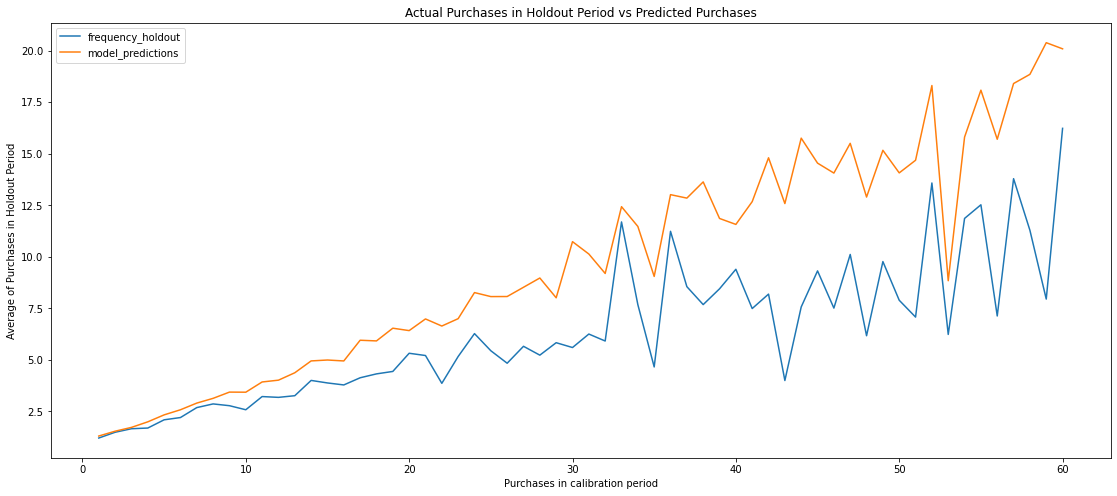

In [0]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_calibration_purchases_vs_holdout_purchases(
  model, 
  filtered_cal_pd, 
  n=60, 
  **{'figsize':(19,8)}
  )

display()

#6. Tunning Model

In [0]:
## Tunining Model

from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, STATUS_FAIL, space_eval
# define search space
search_space = hp.choice('model_type',[
                  {'type':'Pareto/NBD', 'l2':hp.uniform('pareto_nbd_l2', 0.0, 1.0)},
                  {'type':'BG/NBD'    , 'l2':hp.uniform('bg_nbd_l2', 0.0, 1.0)}  
                  ]
                )

# define function for model evaluation
def evaluate_model(params):
  
  # accesss replicated input_pd dataframe
  data = inputs.value
  
  # retrieve incoming parameters
  model_type = params['type']
  l2_reg = params['l2']
  
  # instantiate and configure the model
  if model_type == 'BG/NBD':
    model = BetaGeoFitter(penalizer_coef=l2_reg)
  elif model_type == 'Pareto/NBD':
    model = ParetoNBDFitter(penalizer_coef=l2_reg)
  else:
    return {'loss': None,'status': STATUS_FAIL}
  
  # fit the model
  model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])
  
  # evaluate the model
  frequency_holdout_actual = data['frequency_holdout']
  frequency_holdout_predicted = model.predict(data['duration_holdout'], data['frequency_cal'], data['recency_cal'], data['T_cal'])
  mse = score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')
  
  # return score and status
  return {'loss': mse,'status': STATUS_OK}

In [0]:
import mlflow

# replicate input_pd dataframe to workers in Spark cluster
inputs = sc.broadcast(filtered_cal_pd)

# configure hyperopt settings to distribute to all executors on workers
spark_trials = SparkTrials(parallelism=2)

# select optimization algorithm
algo = tpe.suggest

# perform hyperparameter tuning (logging iterations to mlflow)
argmin = fmin(
  fn=evaluate_model,
  space=search_space,
  algo=algo,
  max_evals=50,
  trials=spark_trials,
  verbose=True
  )

# release the broadcast dataset
inputs.unpersist()

In [0]:
print(space_eval(search_space, argmin))

{'l2': 0.0014409323991287615, 'type': 'Pareto/NBD'}

In [0]:
# get hyperparameter settings
#params = space_eval(search_space, argmin)
#model_type = params['type']
#l2_reg = params['l2']

model_type = 'Pareto/NBD'
l2_reg = 0.0014409323991287615




# instantiate and configure model
if model_type == 'BG/NBD':
  model = BetaGeoFitter(penalizer_coef=l2_reg)
elif model_type == 'Pareto/NBD':
  model = ParetoNBDFitter(penalizer_coef=l2_reg)
else:
  raise 'Unrecognized model type'
  
# train the model
model.fit(filtered_cal_pd['frequency_cal'], filtered_cal_pd['recency_cal'], filtered_cal_pd['T_cal'])

# score the model
frequency_holdout_actual = filtered_cal_pd['frequency_holdout']
frequency_holdout_predicted = model.predict(filtered_cal_pd['duration_holdout'], filtered_cal_pd['frequency_cal'], filtered_cal_pd['recency_cal'], filtered_cal_pd['T_cal'])
mse = score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')

print('MSE: {0}'.format(mse))
print('MAE: {0}'.format(mean_absolute_error(frequency_holdout_actual, frequency_holdout_predicted))) 

/databricks/python/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
 return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/databricks/python/lib/python3.8/site-packages/scipy/special/_logsumexp.py:108: RuntimeWarning: overflow encountered in exp
 tmp = b * np.exp(a - a_max)
MSE: 58.26962494605814
MAE: 3.529204427333621

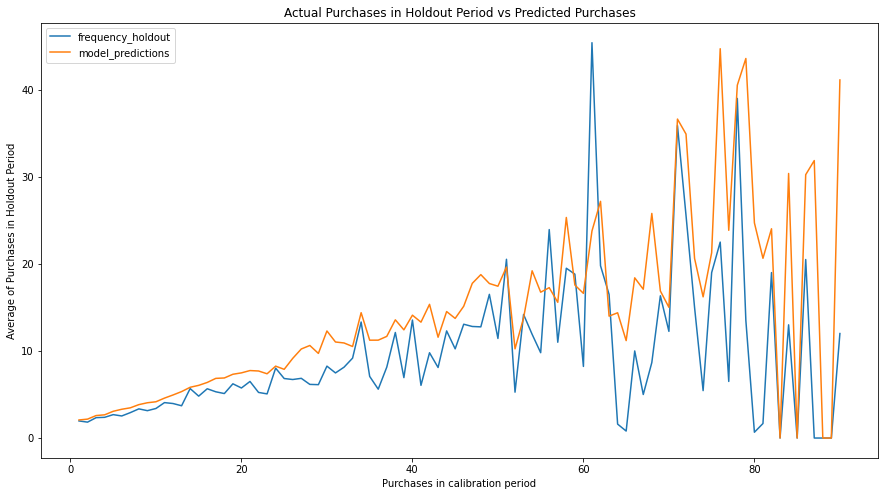

In [0]:
plot_calibration_purchases_vs_holdout_purchases(
  model, 
  filtered_cal_pd, 
  n=90, 
  **{'figsize':(15,8)}
  )

display()

#7. Prediction

In [0]:
# add a field with the probability a customer is currently "alive"
filtered_pd['prob_alive']=model.conditional_probability_alive(
    filtered_pd['frequency'], 
    filtered_pd['recency'], 
    filtered_pd['T']
    )
filtered_pd['% of prob_alive'] = round((filtered_pd['prob_alive'] *100),2)


filtered_pd['purchases_next60days']=(
  model.conditional_expected_number_of_purchases_up_to_time(
    60, 
    filtered_pd['frequency'], 
    filtered_pd['recency'], 
    filtered_pd['T']
    )
  )


filtered_pd.head(10)

#7. ดึง Last Purchase ของ กลุ่มตัวอย่าง ที่อยู่ในช่วง เดือน 2 -3 เพื่อที่จะไปหา Accurate

In [0]:
df_get_last = df_rfa_2_1[df_rfa_2_1['SuccessDate_2'] < '2021-01-01']

In [0]:
## ดึง กลุ่มตัวอย่าง ที่มี Last Active ในช่วงเดือน Dec 01 - Jan 01

user_last_purchase = df_get_last.groupby(['id']).agg({'SuccessDate_2':max})\
                    .rename(columns={'SuccessDate_2' : 'last_purchase'}).reset_index()

user_last_pur = user_last_purchase[(user_last_purchase['last_purchase'] >= '2020-12-01') & 
                                  (user_last_purchase['last_purchase'] <= '2021-01-01')]

In [0]:
filtered_pd_aa = filtered_pd[filtered_pd['id'].isin(user_last_pur['id'].unique())]

In [0]:
filtered_pd_aa

#8 หา Purchase Actual ของ กลุ่มตัวอย่าง ที่มีการ Purchase ในเดือน 2-3

In [0]:
actual_frequency_2 = df_rfa_2_1[(df_rfa_2_1['SuccessDate_2'] >= '2021-01-01') & 
                                      (df_rfa_2_1['SuccessDate_2'] <= '2021-03-02')]



df_lapse_formap = autolaps[['id','productname','successdate','consumptiondays','repurchase_alrt']]

df_lapse_formap_1 = df_lapse_formap[(df_lapse_formap['SuccessDate'] >= '2021-01-01') & 
                                      (df_lapse_formap['SuccessDate'] <= '2021-03-02')]
df_lapse_formap_1

In [0]:
actual_frequency_2 = actual_frequency_2[['id','SuccessDate','SuccessDate_2']]

In [0]:
actual_frequency_2

In [0]:
df_lapse_formap_1_1 = df_lapse_formap_1.groupby(['id','SuccessDate']).sum().reset_index()

In [0]:
test = actual_frequency_2.merge(df_lapse_formap_1_1 ,on=['id','SuccessDate'] , how='left')

In [0]:
test.head()

In [0]:
test.shape

Out[286]: (68710, 4)

In [0]:
test_1 = test.merge(df_lapse_formap_1.drop(columns='consumptiondays').drop_duplicates(),
           on=['id','SuccessDate'] , how='left')

In [0]:
test_1

In [0]:
test_1['consumptiondays'] = test_1['consumptiondays'].fillna(13)

In [0]:
test_1.sort_values(by='consumptiondays' , ascending=False)

In [0]:
#test.drop(columns='SuccessDate_2' , inplace=True)
test_1 = test_1[test_1['consumptiondays'] <= 65]

In [0]:
test_2 = test_1.groupby(['id'],as_index=False)\
                  .agg({'SuccessDate_2':'nunique'})\
                  .rename(columns={'SuccessDate_2':'Frequency_count_date'})

In [0]:
test_2.sort_values(by='Frequency_count_date' ,ascending=False)

In [0]:
cut = filtered_pd_aa.merge(test_2,on=['id'],how='left' ).fillna(0)

In [0]:
cut.sort_values(by='% of prob_alive')

In [0]:
cut.shape

Out[399]: (5874, 8)

In [0]:
cut[cut['purchases_next60days'] < 3.2]

In [0]:
nb = Threshold_explore(cut,cut['purchases_next60days'].max())
nb.iloc[60:100]

Out[401]:

,prd_purchase_key,score,count_user,count_user_isactual
60,prd_purchase =6.1,0.748,5334,3989
61,prd_purchase =6.2,0.749,5358,4011
62,prd_purchase =6.3,0.750,5384,4037
63,prd_purchase =6.4,0.750,5411,4059
64,prd_purchase =6.5,0.751,5432,4078
65,prd_purchase =6.6,0.751,5454,4098
66,prd_purchase =6.7,0.752,5470,4114
67,prd_purchase =6.8,0.753,5493,4135
68,prd_purchase =6.9,0.753,5508,4148
69,prd_purchase =7.0,0.754,5529,4168
